<a href="https://colab.research.google.com/github/GiovaniValdrighi/inferencia_causal/blob/master/vae/scm_counterfactual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
!pip3 install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl
!pip3 install torchvision
!pip3 install pyro-ppl

ERROR: torch-0.4.0-{platform}-linux_x86_64.whl is not a valid wheel filename.
     |████████████████████████████████| 491kB 2.8MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
import numpy as np
import torch
from vae_build import VAE, ind_from_att, label_from_dummy, dummy_from_label
import pyro
import matplotlib.pyplot as plt
from pyro.distributions import OneHotCategorical, RelaxedOneHotCategorical, Normal, Uniform, constraints, Categorical
from torch import tensor

In [6]:
dataset_zip = np.load('/content/gdrive/My Drive/autoencoder/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle = True, encoding = 'bytes')
print('Keys in the dataset:', dataset_zip.files)
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
latents_sizes = dataset_zip['metadata'][()][b'latents_sizes']
latents_names = dataset_zip['metadata'][()][b'latents_names']

Keys in the dataset: ['metadata', 'imgs', 'latents_classes', 'latents_values']


In [7]:
pyro.enable_validation(True)
pyro.clear_param_store()
#the training routine
use_CUDA = False
vae = VAE(latents_sizes, latents_names, use_CUDA = use_CUDA)
vae.load_state_dict(torch.load('/content/gdrive/My Drive/trained_movel_epoch_24.save'))

<All keys matched successfully>

#Importance Sampling 
Estou utilizando o método de Importance Sampling para realizar o cálculo de contra factuais no modelo.

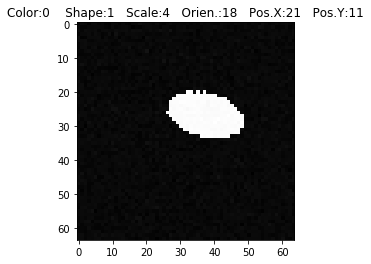

In [8]:
class SCM():
  def __init__(self, vae):
    self.vae = vae
    self.latents_names = ['color', 'shape', 'scale', 'orien', 'posX', 'posY']
    self.latents_sizes = {'color' : 1, 'shape': 3, 'scale':6, 'orien': 40, 'posX': 32, 'posY':32}
    dist = OneHotCategorical
    self.init_noise = {'color': dist(tensor([1.])),
                       'shape': dist(tensor([0.4, 0.4, 0.2])),
                       'scale': dist(tensor([1/6]).repeat(6)),
                       'orien': dist(tensor([1/40]).repeat(40)),
                       'posX': dist(tensor([1/32]).repeat(32)),
                       'posY': dist(tensor([1/32]).repeat(32)),
                       'latent': Normal(torch.zeros(200), torch.ones(200)),
                       'img': Uniform(torch.zeros(4096), torch.ones(4096))}
    
    #functions for the model
    def f_gumbel(N):
      return N
    
    def f_posX(N, scale):
      if 31 <= int(scale.max(0)[1] + N.max(0)[1]):
        return torch.nn.functional.one_hot(torch.tensor([31]), 32).to(torch.float32).reshape([32])
      else:
        return torch.nn.functional.one_hot(scale.max(0)[1] + N.max(0)[1], 32).to(torch.float32).reshape([32])

    def f_latent(N_latent, color, shape, scale, orien, posX, posY):
      ind = ind_from_att(color.max(0)[1], shape.max(0)[1], scale.max(0)[1], orien.max(0)[1], posX.max(0)[1], posY.max(0)[1])
      label = torch.round(torch.cat([color, shape, scale, orien, posX, posY], -1))
      mu, sigma = vae.encoder.forward(torch.tensor(imgs[ind]).reshape(4096).to(torch.float32), label)
      return N_latent * sigma + mu

    def f_image(N_img, latent, color, shape, scale, orien, posX, posY):
      label = torch.round(torch.cat([color, shape, scale, orien, posX, posY], -1))
      img_decode = vae.decoder.forward(latent, label)
      return (N_img > img_decode).to(torch.float)

 
    def model(noise = self.init_noise):

      #Noise variables
      N_color = pyro.sample('N_color', noise['color'])
      N_shape = pyro.sample('N_shape', noise['shape'])
      N_scale = pyro.sample('N_scale', noise['scale'])
      N_orien = pyro.sample('N_orien', noise['orien'])
      N_posX = pyro.sample('N_posX', noise['posX'])
      N_posY = pyro.sample('N_posY', noise['posY'])
      N_latent = pyro.sample('N_latent', noise['latent'].to_event(1))
      N_img = pyro.sample('N_img', noise['img'].to_event(1))

      #variables
      color = pyro.sample('color', Normal(f_gumbel(N_color), torch.tensor([0.01])).to_event(1))
      shape = pyro.sample('shape', Normal(f_gumbel(N_shape), torch.tensor([0.01])).to_event(1))
      scale = pyro.sample('scale', Normal(f_gumbel(N_scale), torch.tensor([0.01])).to_event(1))
      orien = pyro.sample('orien', Normal(f_gumbel(N_orien), torch.tensor([0.01])).to_event(1))
      posX = pyro.sample('posX', Normal(f_posX(N_posX, scale), torch.tensor([0.01])).to_event(1))
      posY = pyro.sample('posY', Normal(f_gumbel(N_posY), torch.tensor([0.01])).to_event(1))

      #variables
      latent = pyro.sample('latent', Normal(f_latent(N_latent, color, shape, scale, orien, posX, posY), torch.tensor([0.01])).to_event(1))
      img = pyro.sample('img', Normal(f_image(N_img, latent, color, shape, scale, orien, posX, posY), torch.tensor([0.01])).to_event(1))

      return torch.round(torch.cat([color, shape, scale, orien, posX, posY], -1)), latent, img
    
    def guide(noise = self.init_noise):
      
      #params
      cat_val =  {'color': 1, 'shape': 3, 'scale': 6, 'orien': 40, 'posX': 32, 'posY': 32}
      probs = {key : pyro.param('prob_'+key, tensor(1/value).repeat(value), constraint = constraints.positive) for key, value in cat_val.items()}
      mu_latent = pyro.param('mu_latent', torch.ones(200)*0.5)
      sigma_latent = pyro.param('sigma_latent', torch.ones(200)*0.2, constraint = constraints.positive)
      low_img = pyro.param('low_img', torch.ones(4096)*0.5, constraint = constraints.interval(0., 1.))
      high_img = pyro.param('high_img', torch.ones(4096)*0.02, constraint = constraints.interval(0., 1.))
      
      #noise variables
      N_color = pyro.sample('N_color', OneHotCategorical(probs['color']))
      N_shape = pyro.sample('N_shape', OneHotCategorical(probs['shape']))
      N_scale = pyro.sample('N_scale', OneHotCategorical(probs['scale']))
      N_orien = pyro.sample('N_orien', OneHotCategorical(probs['orien']))
      N_posX = pyro.sample('N_posX', OneHotCategorical(probs['posX']))
      N_posY = pyro.sample('N_posY', OneHotCategorical(probs['posY']))
      N_latent = pyro.sample('N_latent', Normal(mu_latent, sigma_latent).to_event(1))
      N_img = pyro.sample('N_img', Normal(low_img, high_img).to_event(1))
      #print(sum(N_img > 1))
      #print(sum(N_img < 0))
      #variables
      #color = pyro.sample('color', Normal(f_gumbel(N_color), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      #shape = pyro.sample('shape', Normal(f_gumbel(N_shape), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      #scale = pyro.sample('scale', Normal(f_gumbel(N_scale), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      #orien = pyro.sample('orien', Normal(f_gumbel(N_orien), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      #posX = pyro.sample('posX', Normal(f_gumbel(N_posX), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      #posY = pyro.sample('posY', Normal(f_gumbel(N_posY), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      #latent = pyro.sample('latent', Normal(f_latent(N_latent, color, shape, scale, orien, posX, posY), tensor(0.01)).to_event(1))
      #img = pyro.sample('img', Normal(f_image(N_img, latent, color, shape, scale, orien, posX, posY), tensor(0.01)).to_event(1))

      return 
    
    

    def viz_model():
      label, _, img = model()
      label = label_from_dummy(label)
      plt.imshow(img.detach().numpy().reshape(64, 64), cmap = 'Greys')
      text = 'Color:0    Shape:'+str(int(label[1])) + '   Scale:' + str(int(label[2])) + '   Orien.:' + str(int(label[3])) + '   Pos.X:' + str(int(label[4])) + '   Pos.Y:' + str(int(label[5]))
      plt.title(text)
      plt.show()

    self.model = model
    self.guide = guide
    self.viz_model = viz_model


scm = SCM(vae)
scm.viz_model()

In [0]:
obs_data = {'color': tensor([1.]),
            'shape': tensor([0., 1., 0.]),
            'scale': tensor([0., 0., 0., 1., 0., 0]),
            'orien': torch.nn.functional.one_hot(tensor(17), 40).to(torch.float32),
            'posX': torch.nn.functional.one_hot(tensor(0), 32).to(torch.float32),
            'posY': torch.nn.functional.one_hot(tensor(5), 32).to(torch.float32)}
obsModel = pyro.condition(scm.model, data = obs_data)
int_data = obs_data.copy()
int_data['shape'] = tensor([1., 0., 0.])
intModel = pyro.do(scm.model, int_data)

posterior = pyro.infer.Importance(scm.model, scm.guide, num_samples = 1000).run(scm.init_noise)
updated_noise = {'color' : pyro.infer.EmpiricalMarginal(posterior, sites = 'N_color'),
                 'shape': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_shape'),
                 'scale': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_scale'),
                 'orien': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_orien'),
                 'posX': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_posX'),
                 'posY': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_posY'),
                 'latent': Normal(torch.zeros(200), torch.ones(200)),
                 'img': Uniform(torch.zeros(4096), torch.ones(4096))}
counterfactual_posterior = pyro.infer.Importance(intModel, num_samples = 1000).run(updated_noise)
marginal_counterfactual = pyro.infer.EmpiricalMarginal(counterfactual_posterior, sites = "img")
img_counterfactual = marginal_counterfactual.mean

condition_posterior = pyro.infer.Importance(obsModel, num_samples = 1000).run(scm.init_noise)
marginal_condition = pyro.infer.EmpiricalMarginal(condition_posterior, sites = 'img')
img_condition = marginal_condition.mean

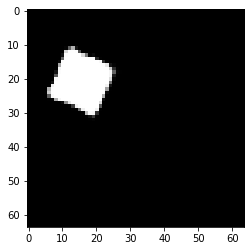

In [28]:
plt.imshow(img_counterfactual.detach().numpy().reshape(64, 64), cmap = 'Greys')
plt.show()

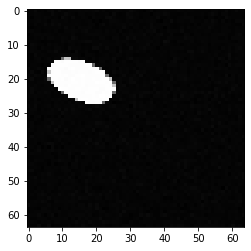

In [29]:
plt.imshow(img_condition.detach().numpy().reshape(64, 64), cmap = 'Greys')
plt.show()

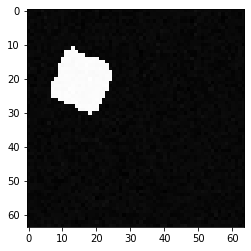

In [30]:
plt.imshow(marginal_img().detach().numpy().reshape(64, 64), cmap = 'Greys')
plt.show()

In [0]:
scm.init_noise

{'color': OneHotCategorical(),
 'img': Uniform(low: torch.Size([4096]), high: torch.Size([4096])),
 'latent': Normal(loc: torch.Size([200]), scale: torch.Size([200])),
 'orien': OneHotCategorical(),
 'posX': OneHotCategorical(),
 'posY': OneHotCategorical(),
 'scale': OneHotCategorical(),
 'shape': OneHotCategorical()}

In [0]:
#condition algoritm
obs = {'color': tensor([1.]),
      'shape': tensor([0., 1., 0.]),
      'orien': torch.zeros(40),
      'posX': torch.zeros(32),
      'posY': torch.zeros(32)}
obs['orien'][17] = 1.
obs['posY'][3] = 1.
obs['posX'][4] = 1.
obs['scale'] = tensor([1.0, 0., 0., 0., 0., 0.])
condModel = pyro.condition(scm.model, data = obs)
pyro.clear_param_store()

var_shapes = {'color': 1, 'shape':3, 'scale':6, 'orien':40, 'posX':32, 'posY':32}

#setting the SVI attributes
adam_params = {'lr': 0.01}
optmizer = pyro.optim.Adam(adam_params)
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(condModel, scm.guide, optmizer, elbo)

#training loop
losses = []
prob_samples = {key : [] for key in var_shapes.keys()}
mu_samples = []
sigma_samples = []
low_samples = []
high_samples = []

for i in range(500):
  losses.append(svi.step(scm.init_noise))
  #saving samples
  for key in var_shapes.keys():
    prob_samples[key].append(pyro.param('prob_'+key))
  mu_samples.append(pyro.param('mu_latent'))
  sigma_samples.append(pyro.param('sigma_latent'))
  low_samples.append(pyro.param('low_img'))
  high_samples.append(pyro.param('high_img'))

#calculating means
for key in var_shapes.keys():
  prob_samples[key] = torch.mean(torch.stack(prob_samples[key]), dim = 0)
mu_samples = torch.mean(torch.stack(mu_samples), dim = 0)
sigma_samples = torch.mean(torch.stack(sigma_samples), dim = 0)
low_samples = torch.mean(torch.stack(low_samples),dim = 0)
high_samples = torch.mean(torch.stack(high_samples), dim = 0)

updated_noise = {}
for key in var_shapes.keys():
  updated_noise[key] = OneHotCategorical( prob_samples[key])
updated_noise['latent'] = Normal(mu_samples, sigma_samples)
updated_noise['img'] =  Normal(low_samples, high_samples)
img_samples = []
for _ in range(1000):
  _, _, s = scm.model(updated_noise)
  img_samples.append(s)
img_samples = torch.mean(torch.stack(img_samples), dim = 0)
print(prob_samples)

{'color': tensor([1.], grad_fn=<MeanBackward1>), 'shape': tensor([0.3325, 0.3336, 0.3344], grad_fn=<MeanBackward1>), 'scale': tensor([0.1682, 0.1675, 0.1670, 0.1668, 0.1662, 0.1661],
       grad_fn=<MeanBackward1>), 'orien': tensor([0.0250, 0.0251, 0.0250, 0.0250, 0.0251, 0.0250, 0.0253, 0.0251, 0.0250,
        0.0250, 0.0250, 0.0251, 0.0251, 0.0250, 0.0251, 0.0250, 0.0250, 0.0251,
        0.0252, 0.0251, 0.0251, 0.0250, 0.0252, 0.0251, 0.0250, 0.0250, 0.0251,
        0.0251, 0.0252, 0.0250, 0.0250, 0.0250, 0.0250, 0.0252, 0.0253, 0.0251,
        0.0251, 0.0254, 0.0250, 0.0252], grad_fn=<MeanBackward1>), 'posX': tensor([0.0312, 0.0318, 0.0314, 0.0313, 0.0313, 0.0314, 0.0313, 0.0313, 0.0313,
        0.0315, 0.0313, 0.0313, 0.0313, 0.0313, 0.0313, 0.0315, 0.0314, 0.0314,
        0.0315, 0.0313, 0.0314, 0.0312, 0.0313, 0.0313, 0.0314, 0.0312, 0.0313,
        0.0313, 0.0312, 0.0313, 0.0314, 0.0312], grad_fn=<MeanBackward1>), 'posY': tensor([0.0314, 0.0313, 0.0315, 0.0313, 0.0313, 0.0314, 0

In [0]:
def t_mean(tens):
  return torch.mean(torch.stack(tens), dim = 0)

def dummy(shape, scale, orien, posX, posY):
  t = []
  t.append(tensor([1]))
  t.append(torch.nn.functional.one_hot(tensor(shape), 3))
  t.append(torch.nn.functional.one_hot(tensor(scale), 6))
  t.append(torch.nn.functional.one_hot(tensor(orien), 40))
  t.append(torch.nn.functional.one_hot(tensor(posX), 32))
  t.append(torch.nn.functional.one_hot(tensor(posY), 32))
  return torch.cat(t, -1).to(torch.float32)

class SCM_test():
  def __init__(self, vae):
    self.vae = vae
    self.latents_names = ['shape', 'scale', 'orien', 'posX', 'posY']
    dist = Categorical
    self.init_noise = {'shape': dist(tensor([.4, .4, .2])),
                       'scale': dist(tensor([1., 2., 2., 2., 2., 1.])),
                       'orien': dist(tensor(1/40).repeat(40)),
                       'posY': dist(tensor(1/40).repeat(40)),
                       'posX': dist(tensor(1/32).repeat(32)),
                       'latent': Normal(torch.zeros(200), torch.ones(200)),
                       'img': Uniform(torch.zeros(4096), torch.ones(4096))}

    def f_latent(N_latent, shape, scale, orien, posX, posY):
      shape = int(torch.round(shape))
      scale = int(torch.round(scale))
      orien = int(torch.round(orien))
      posX = int(torch.round(posX))
      posY = int(torch.round(posY))

      ind = ind_from_att(0, shape, scale, orien, posX, posY)
      label = dummy(shape, scale, orien, posX, posY)
      mu, sigma = vae.encoder.forward(torch.tensor(imgs[ind]).reshape(4096).to(torch.float32), label)
      return N_latent * sigma + mu

    def f_image(N_img, latent, color, shape, scale, orien, posX, posY):
      shape = int(torch.round(shape))
      scale = int(torch.round(scale))
      orien = int(torch.round(orien))
      posX = int(torch.round(posX))
      posY = int(torch.round(posY))
      label = dummy(shape, scale, orien, posX, posY)
      img_decode = vae.decoder.forward(latent, label)
      return (N_img > img_decode).to(torch.float32)
    
    def f_cat(N):
      return N.to(torch.float32)

    def f_posX(N, scale):
      if 31 <= N+scale:
        return tensor(31., dtype = torch.float32)
      else:
        return tensor(N+scale, dtype = torch.float32)

    def model(noise  = self.init_noise):
      #noise variables
      N_shape = pyro.sample('N_shape', noise['shape'])
      N_scale = pyro.sample('N_scale', noise['scale'])
      N_orien = pyro.sample('N_orien', noise['orien'])
      N_posX = pyro.sample('N_posX', noise['posX'])
      N_posY = pyro.sample('N_posY', noise['posY'])
      N_latent = pyro.sample('N_latent', noise['latent'].to_event(1))
      N_img = pyro.sample('N_img', noise['img'].to_event(1))
      #variables
      shape = pyro.sample('shape', Normal(f_cat(N_shape), tensor(0.01)))
      scale = pyro.sample('scale', Normal(f_cat(N_scale), tensor(0.01)))
      orien = pyro.sample('orien', Normal(f_cat(N_orien), tensor(0.01)))
      posX = pyro.sample('posX', Normal(f_posX(N_posX, scale), tensor(0.01)))
      posY = pyro.sample('posY', Normal(f_cat(N_posY), tensor(0.01)))

      latent = pyro.sample('latent', Normal(f_latent(N_latent, shape, scale, orien, posX, posY), tensor(0.01)).to_event(1))
      img = pyro.sample('img', Normal(f_image(N_img, latent, tensor([1.]), shape, scale, orien, posX, posY), tensor(0.01)).to_event(1))
      return shape, scale, orien, posX, posY, latent, img

    def guide(noise = self.init_noise):
      #noise params
      prob_shape = pyro.param('prob_shape', tensor(1/3).repeat(3), constraint = constraints.positive)
      prob_scale = pyro.param('prob_scale', tensor(1/6).repeat(6), constraint = constraints.positive)
      prob_orien = pyro.param('prob_orien', tensor(1/40).repeat(40), constraint = constraints.positive)
      prob_posX = pyro.param('prob_posX', tensor(1/32).repeat(32), constraint = constraints.positive)
      prob_posY = pyro.param('prob_posY', tensor(1/32).repeat(32), constraint = constraints.positive)
      mu = {}
      sigma = {}
      mu['latent'] = pyro.param('mu_latent', torch.ones(200)*0.01)
      sigma['latent'] = pyro.param('sigma_latent', torch.ones(200), constraint = constraints.positive)
      mu['img'] = pyro.param('mu_img', torch.ones(4096)*.01, constraint = constraints.interval(0.001, 0.99))
      sigma['img'] = pyro.param('sigma_img', torch.ones(4096), constraint = constraints.interval(0.001, 0.99))
      #noise variables
      N_shape = pyro.sample('N_shape', Categorical(prob_shape))
      N_scale = pyro.sample('N_scale', Categorical(prob_scale))
      N_orien = pyro.sample('N_orien', Categorical(prob_orien))
      N_posX= pyro.sample('N_posX', Categorical(prob_posX))
      N_posY= pyro.sample('N_posY', Categorical(prob_posY))
      N_latent = pyro.sample('N_latent', Normal(mu['latent'], sigma['latent']).to_event(1))
      N_img = pyro.sample('N_img', Uniform(mu['img'], sigma['img']).to_event(1))
      #variables
      shape = pyro.sample('shape', Normal(f_cat(N_shape), tensor(0.01)), infer={'is_auxiliary': True})
      scale = pyro.sample('scale', Normal(f_cat(N_scale), tensor(0.01)), infer={'is_auxiliary': True})
      orien = pyro.sample('orien', Normal(f_cat(N_orien), tensor(0.01)), infer={'is_auxiliary': True})
      posX = pyro.sample('posX', Normal(f_cat(N_posX), tensor(0.01)), infer={'is_auxiliary': True})
      posY = pyro.sample('posY', Normal(f_cat(N_posY), tensor(0.01)), infer={'is_auxiliary': True})
      latent = pyro.sample('latent', Normal(f_latent(N_latent, shape, scale, orien, posX, posY), tensor(0.01)).to_event(1))
      img = pyro.sample('img', Normal(f_image(N_img, latent, tensor([1.]), shape, scale, orien, posX, posY), tensor(0.01)).to_event(1))
      return

    self.model = model
    self.guide = guide

def svi_calculate(scm, datacond, lr, betas, n_steps):
  condModel = pyro.condition(scm.model, data = datacond)
  pyro.clear_param_store()

  #setting the SVI attributes
  args = {'lr': lr, 'betas': betas}
  optmizer = pyro.optim.Adam(args)
  elbo = pyro.infer.Trace_ELBO()
  svi = pyro.infer.SVI(condModel, scm.guide, optmizer, elbo)
  var1 = ['shape', 'scale', 'orien', 'posX','posY']
  var2 = ['latent', 'img']
  #training loop
  cat_samples = {key:[] for key in var1}
  mu_samples = {key : [] for key in var2}
  sigma_samples = {key: [] for key in var2}
  losses = []
  for i in range(n_steps):
    losses.append(svi.step(scm.init_noise))
    #saving samples
    for key in var1:
      cat_samples[key].append(pyro.param('prob_'+key))
      #print(key, cat_samples[key][-1])
    for key in var2:
      mu_samples[key].append(pyro.param('mu_'+key))
      sigma_samples[key].append(pyro.param('sigma_'+key))
      #print(key, mu_samples[key][-1])
      #print(key, sigma_samples[key][-1])
  for key in var1:
    cat_samples[key] = t_mean(cat_samples[key])
  for key in var2:
    mu_samples[key] = t_mean(mu_samples[key])
    sigma_samples[key] = t_mean(sigma_samples[key])

  updated_noise = {key : Categorical(cat_samples[key]) for key in var1}
  updated_noise['latent'] = Normal(mu_samples['latent'], sigma_samples['latent'])
  updated_noise['img'] = Normal(mu_samples['img'], sigma_samples['img'])
  samples = {key:[] for key in var1}
  img_samples = []
  for _ in range(1000):
    sh, sc, ori, px, py, _, im = scm.model(updated_noise)
    samples['shape'].append(sh)
    samples['scale'].append(sc)
    samples['orien'].append(ori)
    samples['posX'].append(px)
    samples['posY'].append(py)
    img_samples.append(im)
  for key in var1:
    samples[key] = t_mean(samples[key])
  img_samples = t_mean(img_samples)
  print('=====================')
  print('SVI')
  print('The SVI was run with ' + str(n_steps) + ' steps. The Adam lr was ' + str(lr) + ' and the betas interval was ' + str(betas) + '.')
  print('Graph of loss:')
  plt.figure()
  plt.plot(range(len(losses)), losses)
  print('The conditioned values was:')
  print('Shape: '+ str(datacond['shape']))
  print('Scale: '+ str(datacond['scale']))
  print('Orien: '+ str(datacond['orien']))
  print('PosX: '+ str(datacond['posX']))
  print('PosY: '+ str(datacond['posY']))
  print('The infered values was:')
  print('Shape: '+ str(samples['shape']))
  print('Scale: '+ str(samples['scale']))
  print('Orien: '+ str(samples['orien']))
  print('PosX: '+ str(samples['posX']))
  print('PosY: '+ str(samples['posY'])) 
  print('The image sampled was:')
  plt.figure()
  plt.imshow(img_samples.detach().numpy().reshape(64, 64))
  plt.show()   


In [0]:
scm = SCM_test(vae)
data = {'shape': tensor([1.]),
        'scale': tensor([3.]),
        'orien': tensor([0.]),
        'posX': tensor([0.]),
        'posY': tensor([0.])}
svi_calculate(scm, data, 0.08, [0.1, 0.99], 1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


KeyboardInterrupt: ignored

In [0]:
pyro.infer.SVI()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{'shape': tensor([0.3332, 0.3296, 0.3413], grad_fn=<MeanBackward1>), 'scale': tensor([0.1651, 0.1667, 0.1733, 0.1689, 0.1714, 0.1669],
       grad_fn=<MeanBackward1>), 'orien': tensor([0.0273, 0.0287, 0.0314, 0.0250, 0.0264, 0.0272, 0.0258, 0.0262, 0.0263,
        0.0282, 0.0258, 0.0277, 0.0260, 0.0292, 0.0273, 0.0270, 0.0266, 0.0269,
        0.0267, 0.0261, 0.0266, 0.0259, 0.0275, 0.0261, 0.0289, 0.0252, 0.0255,
        0.0279, 0.0260, 0.0260, 0.0267, 0.0251, 0.0255, 0.0258, 0.0255, 0.0252,
        0.0244, 0.0253, 0.0247, 0.0243], grad_fn=<MeanBackward1>), 'posX': tensor([0.0337, 0.0339, 0.0342, 0.0331, 0.0350, 0.0324, 0.0333, 0.0334, 0.0331,
        0.0324, 0.0352, 0.0320, 0.0330, 0.0318, 0.0327, 0.0321, 0.0322, 0.0331,
        0.0341, 0.0334, 0.0322, 0.0310, 0.0315, 0.0321, 0.0315, 0.0312, 0.0333,
        0.0324, 0.0306, 0.0309, 0.0317, 0.0317], grad_fn=<MeanBackward1>), 'posY': tensor([0.0343, 0.0332, 0.0323, 0.0325, 0.0325, 0.0338, 0.0325, 0.0317, 0.0365,
        0.0324, 0.0340, 0

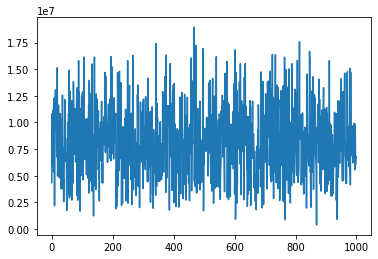

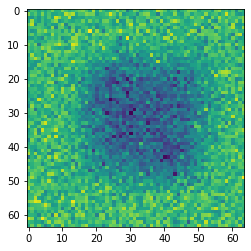

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{'shape': tensor([0.3587, 0.3995, 0.2957], grad_fn=<MeanBackward1>), 'scale': tensor([0.2436, 0.2818, 0.1767, 0.1686, 0.1610, 0.1395],
       grad_fn=<MeanBackward1>), 'orien': tensor([0.0657, 0.0558, 0.0385, 0.0480, 0.0356, 0.0588, 0.0631, 0.0439, 0.0349,
        0.1227, 0.0582, 0.0337, 0.0312, 0.0279, 0.0500, 0.1125, 0.0794, 0.0436,
        0.0430, 0.0756, 0.0555, 0.0314, 0.0504, 0.0290, 0.0500, 0.0608, 0.0282,
        0.0280, 0.0354, 0.0407, 0.0505, 0.0261, 0.0256, 0.0252, 0.0271, 0.0608,
        0.0261, 0.0373, 0.0315, 0.0232], grad_fn=<MeanBackward1>), 'posX': tensor([0.1000, 0.0943, 0.0838, 0.2093, 0.0989, 0.0446, 0.0492, 0.0420, 0.1038,
        0.0371, 0.0350, 0.0551, 0.0554, 0.0457, 0.0384, 0.0703, 0.0372, 0.0581,
        0.0647, 0.0467, 0.0425, 0.0473, 0.0337, 0.0282, 0.0270, 0.0303, 0.0311,
        0.0424, 0.0396, 0.0389, 0.0259, 0.0485], grad_fn=<MeanBackward1>), 'posY': tensor([0.0825, 0.0440, 0.0485, 0.0485, 0.0527, 0.0510, 0.0696, 0.1038, 0.0376,
        0.0531, 0.0877, 0

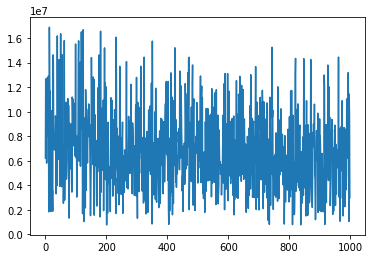

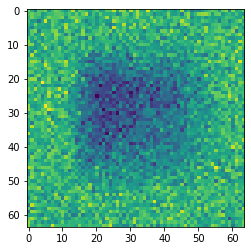

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{'shape': tensor([0.1374, 0.7354, 0.9943], grad_fn=<MeanBackward1>), 'scale': tensor([0.1585, 1.2018, 0.3683, 0.3887, 0.2097, 0.1738],
       grad_fn=<MeanBackward1>), 'orien': tensor([1.1765e+02, 1.9852e-01, 2.4035e-01, 2.5425e-01, 7.2771e-02, 4.8232e-01,
        3.6758e-01, 4.6767e-01, 8.9445e-02, 3.2582e-02, 1.0812e+00, 3.0153e-02,
        6.5198e-02, 2.1551e-01, 7.7367e-01, 3.8776e-01, 4.3605e-02, 6.9731e-02,
        3.7882e-01, 3.1109e-01, 3.1343e-02, 3.2533e-02, 4.9373e-01, 3.9228e-01,
        1.0314e-01, 3.4679e-02, 6.3860e-02, 1.3615e-01, 1.0609e-01, 3.0785e-02,
        6.3607e-01, 6.4186e-02, 5.1187e-02, 3.5261e-02, 3.1816e-01, 1.3084e+00,
        9.3154e-02, 2.9672e-02, 5.9538e-02, 6.9820e-02],
       grad_fn=<MeanBackward1>), 'posX': tensor([1.3629e-01, 4.1769e+00, 5.4439e+00, 8.2158e+00, 1.8019e-01, 3.9188e+01,
        2.0480e-01, 7.1859e-02, 2.0798e-01, 1.3847e-01, 2.9468e-02, 1.1039e-01,
        1.0440e+00, 2.0495e-01, 1.8342e-01, 4.5921e-02, 5.1371e-02, 4.6398e-02,
     

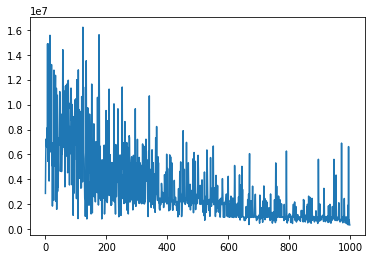

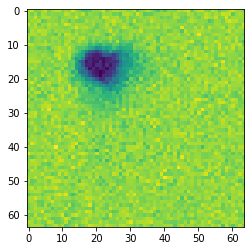

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{'shape': tensor([1.4318, 1.7043, 0.2098], grad_fn=<MeanBackward1>), 'scale': tensor([1.9785, 1.3437, 4.3261, 0.1387, 0.1139, 0.0911],
       grad_fn=<MeanBackward1>), 'orien': tensor([1.8542e-01, 4.5991e+03, 8.4515e-02, 1.4019e+00, 1.3895e-01, 3.1138e+00,
        7.1940e-02, 7.2182e-02, 4.9586e-02, 8.7988e+01, 1.0731e-01, 3.4780e+00,
        3.8660e-02, 2.7961e-02, 3.8174e-02, 1.2004e+00, 4.2044e-02, 2.1159e-01,
        1.8877e-01, 1.4680e-01, 6.9707e-01, 8.8218e-02, 1.5627e-01, 1.2049e-01,
        9.0917e-02, 2.1256e-01, 1.2254e+00, 3.5859e-01, 4.6629e-02, 2.3038e-02,
        4.9309e-02, 2.5741e-01, 1.0823e+00, 3.0203e-02, 1.5660e+00, 1.6135e+00,
        3.2087e-02, 9.6230e-02, 2.7790e-02, 2.4525e-02],
       grad_fn=<MeanBackward1>), 'posX': tensor([8.0968e-02, 8.9183e-02, 1.2938e-01, 4.9895e+00, 5.9394e-02, 1.8251e+03,
        4.6663e-01, 3.6705e+00, 1.2326e-01, 1.3524e-01, 4.2495e+00, 2.1758e+00,
        1.5454e-01, 1.1607e-01, 6.9141e-02, 5.1475e-02, 3.6537e-02, 9.9672e-02,
     

In [0]:
for i in [0.001, 0.01, 0.05, 0.1, 0.15, 0.4, 0.8, 1]:
  svi_calculate(scm, data, i, [0.01, 0.99], 1000)